In [20]:
SEED = 42

import random
import numpy as np
import torch

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [21]:
import torch
import os
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_from_disk
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

BASE_MODEL_PATH = "../model/final"
BASELINE_FP16_PATH = "../model/baseline_fp16"
INT8_PATH = "../model/quantized_int8"
INT4_PATH = "../model/quantized_int4"


Using device: cuda


In [22]:
fp16_model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL_PATH).to(device)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)

print("Final trained model loaded.")


Final trained model loaded.


In [23]:
os.makedirs(BASELINE_FP16_PATH, exist_ok=True)

fp16_model.save_pretrained(BASELINE_FP16_PATH)
tokenizer.save_pretrained(BASELINE_FP16_PATH)

print("Baseline FP16 model saved.")


Baseline FP16 model saved.


In [24]:
int8_config = BitsAndBytesConfig(load_in_8bit=True)

int8_model = AutoModelForSeq2SeqLM.from_pretrained(
    BASE_MODEL_PATH,
    quantization_config=int8_config,
    device_map="auto"
)

print("INT8 quantized model loaded.")


INT8 quantized model loaded.


In [25]:
os.makedirs(INT8_PATH, exist_ok=True)

int8_model.save_pretrained(INT8_PATH)
tokenizer.save_pretrained(INT8_PATH)

print("INT8 model saved.")


INT8 model saved.


In [26]:
int4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

int4_model = AutoModelForSeq2SeqLM.from_pretrained(
    BASE_MODEL_PATH,
    quantization_config=int4_config,
    device_map="auto"
)

print("INT4 quantized model loaded.")


INT4 quantized model loaded.


In [27]:
os.makedirs(INT4_PATH, exist_ok=True)

int4_model.save_pretrained(INT4_PATH)
tokenizer.save_pretrained(INT4_PATH)

print("INT4 model saved.")


INT4 model saved.


In [28]:
#part 2

In [29]:
os.makedirs(INT4_PATH, exist_ok=True)

int4_model.save_pretrained(INT4_PATH)
tokenizer.save_pretrained(INT4_PATH)

print("INT4 model saved.")


INT4 model saved.


In [30]:
import os

def get_model_size(path):
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            total += os.path.getsize(os.path.join(root, f))
    return total / (1024 ** 2)  # MB


In [31]:
models_for_size = {
    "FP16 Baseline": BASELINE_FP16_PATH,
    "INT8 Quantized": INT8_PATH,
    "INT4 Quantized": INT4_PATH
}

for name, path in models_for_size.items():
    size = get_model_size(path)
    print(f"{name:15s} : {size:.2f} MB")


FP16 Baseline   : 233.92 MB
INT8 Quantized  : 112.77 MB
INT4 Quantized  : 98.14 MB


In [32]:
#part 3

In [33]:
dataset_path = Path(r"C:\Users\rahom\arabic_qa_project\data\tokenized_squad_small")
dataset = load_from_disk(str(dataset_path))

print(dataset)


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})


In [34]:
MODEL_PATHS = {
    "fp16": "../model/baseline_fp16",
    "int8": "../model/quantized_int8",
    "int4": "../model/quantized_int4"
}


In [35]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig
import torch, time
from tqdm import tqdm

def evaluate_model(mode, n_samples=2000):

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    model_path = MODEL_PATHS[mode]

    # ---------- Load model ----------
    if mode == "fp16":
        model = AutoModelForSeq2SeqLM.from_pretrained(
            model_path, dtype=torch.float16
        ).cuda()

    elif mode == "int8":
        model = AutoModelForSeq2SeqLM.from_pretrained(
            model_path,
            quantization_config=BitsAndBytesConfig(load_in_8bit=True),
            device_map="auto"
        )

    elif mode == "int4":
        model = AutoModelForSeq2SeqLM.from_pretrained(
            model_path,
            quantization_config=BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_use_double_quant=True
            ),
            device_map="auto"
        )

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.eval()

    predictions, references = [], []
    start_time = time.time()

    for i, ex in enumerate(tqdm(dataset["validation"])):
        if i >= n_samples:
            break

        input_ids = torch.tensor(ex["input_ids"]).unsqueeze(0)
        attention_mask = torch.tensor(ex["attention_mask"]).unsqueeze(0)

        # 🔐 Correct device placement for ALL modes
        if mode == "fp16":
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
        else:
            embed_device = model.get_input_embeddings().weight.device
            input_ids = input_ids.to(embed_device)
            attention_mask = attention_mask.to(embed_device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=64
            )

        pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
        label_ids = [x for x in ex["labels"] if x != -100]
        ref = tokenizer.decode(label_ids, skip_special_tokens=True)

        predictions.append(pred)
        references.append(ref)

    runtime = time.time() - start_time
    peak_vram = torch.cuda.max_memory_allocated() / 1024**2

    del model
    torch.cuda.empty_cache()

    return predictions, references, runtime, peak_vram


In [36]:
models = {
    "FP16 Baseline": "fp16",
    "INT8 Quantized": "int8",
    "INT4 Quantized": "int4"
}

In [38]:
from evaluate import load

metric = load("squad")

results = {}
all_outputs = {}   

for name, mode in models.items():
    print(f"\nEvaluating {name}...")

    predictions, references, runtime, vram = evaluate_model(mode)


    all_outputs[name] = {
        "predictions": predictions,
        "references": references
    }

    preds = [{"id": str(i), "prediction_text": p} for i, p in enumerate(predictions)]
    refs  = [{"id": str(i), "answers": {"text": [r], "answer_start": [0]}} for i, r in enumerate(references)]

    scores = metric.compute(predictions=preds, references=refs)

    results[name] = {
        "EM": round(scores["exact_match"], 4),
        "F1": round(scores["f1"], 4),
        "Time(s)": round(runtime, 2),
        "VRAM(MB)": round(vram, 2),
        "sample_preds": predictions[:5],   # optional: for demo printouts
        "sample_refs": references[:5]
    }

results




Evaluating FP16 Baseline...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:37<00:00,  9.21it/s]



Evaluating INT8 Quantized...


C:\Users\rahom\arabic_qa_project\.venv\lib\site-packages\transformers\quantizers\auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:51<00:00,  3.07it/s]



Evaluating INT4 Quantized...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:11<00:00,  5.39it/s]


{'FP16 Baseline': {'EM': 63.85,
  'F1': 78.1115,
  'Time(s)': 217.19,
  'VRAM(MB)': 774.87,
  'sample_preds': ['1852',
   '1962',
   'Horace Walpole',
   'Shimer College',
   'Jonathan Stewart'],
  'sample_refs': ['1852',
   '1962',
   'Horace Walpole',
   'several regional colleges and universities',
   'Jonathan Stewart']},
 'INT8 Quantized': {'EM': 63.65,
  'F1': 78.0204,
  'Time(s)': 651.54,
  'VRAM(MB)': 682.21,
  'sample_preds': ['1852',
   '1962',
   'Horace Walpole',
   'Shimer College',
   'Jonathan Stewart'],
  'sample_refs': ['1852',
   '1962',
   'Horace Walpole',
   'several regional colleges and universities',
   'Jonathan Stewart']},
 'INT4 Quantized': {'EM': 63.5,
  'F1': 77.8489,
  'Time(s)': 371.02,
  'VRAM(MB)': 636.25,
  'sample_preds': ['1852',
   '1962',
   'Horace Walpole',
   'Shimer College',
   'Jonathan Stewart'],
  'sample_refs': ['1852',
   '1962',
   'Horace Walpole',
   'several regional colleges and universities',
   'Jonathan Stewart']}}

In [39]:
#part 4

In [40]:
import pandas as pd

df = pd.DataFrame(results).T
print(df)


                   EM       F1 Time(s) VRAM(MB)  \
FP16 Baseline   63.85  78.1115  217.19   774.87   
INT8 Quantized  63.65  78.0204  651.54   682.21   
INT4 Quantized   63.5  77.8489  371.02   636.25   

                                                     sample_preds  \
FP16 Baseline   [1852, 1962, Horace Walpole, Shimer College, J...   
INT8 Quantized  [1852, 1962, Horace Walpole, Shimer College, J...   
INT4 Quantized  [1852, 1962, Horace Walpole, Shimer College, J...   

                                                      sample_refs  
FP16 Baseline   [1852, 1962, Horace Walpole, several regional ...  
INT8 Quantized  [1852, 1962, Horace Walpole, several regional ...  
INT4 Quantized  [1852, 1962, Horace Walpole, several regional ...  


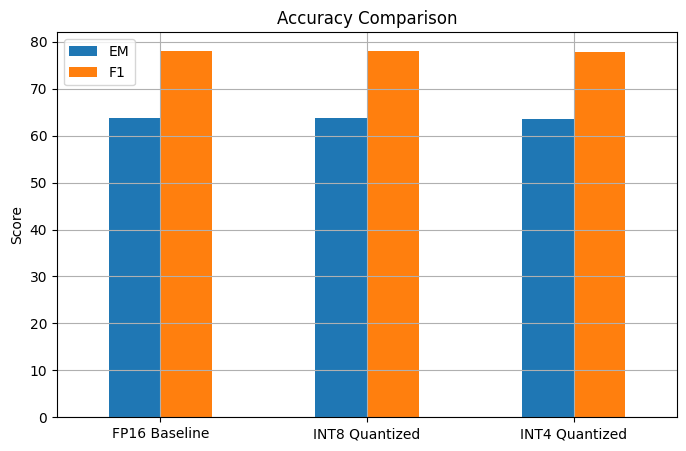

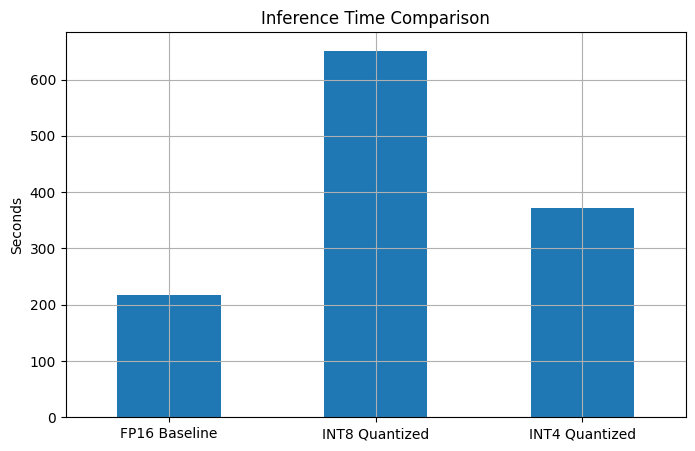

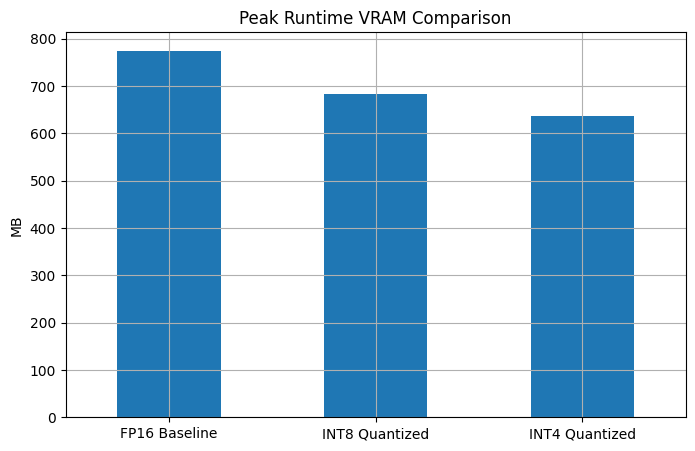

In [42]:
#Clean Visualization Suite
import matplotlib.pyplot as plt

df[["EM", "F1"]].plot(kind="bar", figsize=(8,5))
plt.title("Accuracy Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid()
plt.show()

df["Time(s)"].plot(kind="bar", figsize=(8,5))
plt.title("Inference Time Comparison")
plt.ylabel("Seconds")
plt.xticks(rotation=0)
plt.grid()
plt.show()

df["VRAM(MB)"].plot(kind="bar", figsize=(8,5))
plt.title("Peak Runtime VRAM Comparison")
plt.ylabel("MB")
plt.xticks(rotation=0)
plt.grid()
plt.show()


In [43]:
verify_df = pd.DataFrame({
    "Weight Memory (MB)": {
        "FP16": 139.0,
        "INT8": 109.0,
        "INT4": 94.0
    },
    "Runtime VRAM (MB)": {
        "FP16": results["FP16 Baseline"]["VRAM(MB)"],
        "INT8": results["INT8 Quantized"]["VRAM(MB)"],
        "INT4": results["INT4 Quantized"]["VRAM(MB)"]
    }
})

verify_df



,Weight Memory (MB),Runtime VRAM (MB)
FP16,139.0,774.87
INT8,109.0,682.21
INT4,94.0,636.25


In [45]:
norm_df = df.copy()

for col in ["EM", "F1", "Time(s)", "VRAM(MB)"]:
    norm_df[col] = norm_df[col] / df.loc["FP16 Baseline", col]

norm_df

,EM,F1,Time(s),VRAM(MB),sample_preds,sample_refs
FP16 Baseline,1.0,1.0,1.0,1.0,"[1852, 1962, Horace Walpole, Shimer College, J...","[1852, 1962, Horace Walpole, several regional ..."
INT8 Quantized,0.996868,0.998834,2.999862,0.880419,"[1852, 1962, Horace Walpole, Shimer College, J...","[1852, 1962, Horace Walpole, several regional ..."
INT4 Quantized,0.994518,0.996638,1.708274,0.821105,"[1852, 1962, Horace Walpole, Shimer College, J...","[1852, 1962, Horace Walpole, several regional ..."


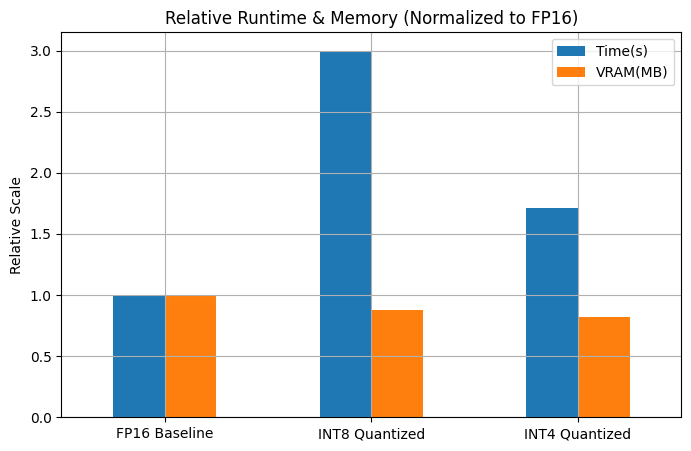

In [46]:
norm_df[["Time(s)", "VRAM(MB)"]].plot(kind="bar", figsize=(8,5))
plt.title("Relative Runtime & Memory (Normalized to FP16)")
plt.ylabel("Relative Scale")
plt.xticks(rotation=0)
plt.grid()
plt.show()


In [54]:
for name in ["FP16 Baseline", "INT8 Quantized", "INT4 Quantized"]:
    preds = all_outputs[name]["predictions"]
    refs  = all_outputs[name]["references"]

    correct = sum(p.strip() == r.strip() for p, r in zip(preds, refs))
    total = len(refs)
    incorrect = total - correct

    print(f"\n{name}")
    print(f"Correct:   {correct}")
    print(f"Incorrect: {incorrect}")
    print(f"EM:        {correct/total:.4f}")



FP16 Baseline
Correct:   1161
Incorrect: 839
EM:        0.5805

INT8 Quantized
Correct:   1158
Incorrect: 842
EM:        0.5790

INT4 Quantized
Correct:   1158
Incorrect: 842
EM:        0.5790


In [52]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig
import torch

def load_demo_model(mode):
    model_path = MODEL_PATHS[mode]

    if mode == "fp16":
        model = AutoModelForSeq2SeqLM.from_pretrained(
            model_path, dtype=torch.float16
        ).cuda()
    else:
        model = AutoModelForSeq2SeqLM.from_pretrained(model_path, device_map="auto")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.eval()
    return model, tokenizer


def qa_demo(context, question):
    print("\n================= DEMO =================\n")
    
    prompt = f"question: {question}  context: {context}"

    for label, mode in [("FP16", "fp16"), ("INT8", "int8"), ("INT4", "int4")]:
        print(f"\n--- {label} ---")

        model, tokenizer = load_demo_model(mode)

        inputs = tokenizer(prompt, return_tensors="pt")

        if mode == "fp16":
            inputs = {k: v.cuda() for k, v in inputs.items()}
        else:
            embed_device = model.get_input_embeddings().weight.device
            inputs = {k: v.to(embed_device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(**inputs, max_length=64)

        answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print("Answer:", answer)

        del model
        torch.cuda.empty_cache()


In [53]:
context = """Istanbul is the largest city in Turkey and serves as the country's economic, cultural, and historic center."""
question = "What is the largest city in Turkey?"

qa_demo(context, question)



================= DEMO =================


--- FP16 ---
Answer: Istanbul

--- INT8 ---
Answer: Istanbul

--- INT4 ---
Answer: Istanbul
